In [41]:
# 原文连接：https://tensorflow.google.cn/tutorials/eager/custom_training_walkthrough?hl=zh-cn

In [42]:
# 代码自动完成
%config IPCompleter.greedy=True

In [14]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

tf.VERSION

'1.10.0'

#### 启用Eager Execution环境

In [3]:
# tf.enable_eager_execution()
tf.contrib.eager.enable_eager_execution()

下载数据集

In [4]:
train_dataset_rul='http://download.tensorflow.org/data/iris_training.csv'
fname=os.path.basename(train_dataset_rul)
origin=train_dataset_rul
train_dataset_fp=tf.keras.utils.get_file(fname=fname,origin=origin)
print('local copy of the dataset file:{}',format(train_dataset_fp))

local copy of the dataset file:{} C:\Users\10321\.keras\datasets\iris_training.csv


In [5]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [6]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [7]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

#### 创建一个Dataset

由于数据集是 CSV 格式的文本文件，请使用 `make_csv_dataset` 函数将数据解析为合适的格式

默认行为是对数据进行随机处理`shuffle=true`

In [8]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

`make_csv_dataset` 函数返回 (features, label) 对的 `tf.data.Dataset`，

其中 features 是一个字典：{'feature_name': value}

In [9]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=60, shape=(32,), dtype=float32, numpy=
              array([6.1, 6.5, 5.3, 4.4, 5.4, 6.4, 5. , 4.6, 5.9, 5.1, 6.7, 6.8, 5.7,
                     6.4, 5.7, 6.4, 5.8, 6.1, 6.7, 7.7, 7.2, 4.9, 4.4, 6.3, 5. , 6.5,
                     6.3, 5.1, 5.1, 5.8, 7.4, 6.4], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=61, shape=(32,), dtype=float32, numpy=
              array([3. , 3. , 3.7, 2.9, 3.4, 3.2, 3.6, 3.6, 3. , 3.8, 3. , 2.8, 2.8,
                     2.8, 3.8, 3.1, 2.8, 2.8, 3.3, 2.6, 3.2, 2.5, 3.2, 2.5, 3.2, 3. ,
                     2.7, 3.8, 3.8, 4. , 2.8, 2.7], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=58, shape=(32,), dtype=float32, numpy=
              array([4.9, 5.2, 1.5, 1.4, 1.5, 4.5, 1.4, 1. , 5.1, 1.5, 5. , 4.8, 4.5,
                     5.6, 1.7, 5.5, 5.1, 4. , 5.7, 6.9, 6. , 4.5, 1.3, 5. , 1.2, 5.8,
                     4.9, 1.6, 1.9, 1.2, 6.1, 5.3],

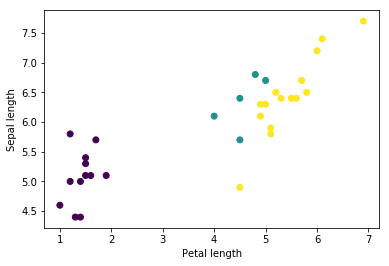

In [13]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [36]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    l=list(features.values())
#     print(l)
#   将多个数据，进行组合。axis=1,按列进行组合。
    features = tf.stack(l, axis=1)
#     print(features)
#     print(tf.transpose(features))
    return features, labels

打包到训练数据集中

In [37]:
train_dataset=train_dataset.map(pack_features_vector)

查看数据样本

In [38]:
features,labels=next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[7.2 3.6 6.1 2.5]
 [6.4 2.7 5.3 1.9]
 [4.6 3.1 1.5 0.2]
 [4.9 2.4 3.3 1. ]
 [6.9 3.1 5.1 2.3]], shape=(5, 4), dtype=float32)


### 选择模型类型

为何要使用模型？
- __模型__是指__特征__与__标签__之间的__关系__
- 传统编程技巧使用大量条件语句创建模型
- 简单的模型可以是几行代数进行描述，复杂的机器学习模型拥有大量难以汇总的参数
- 一个好的机器学习方法可以确定好的模型
- 只需要将足够多的代表性样本馈送到正确类型的机器学习__模型__中，该程序便会找找出与__标签__相应的关系